In [64]:
import os
import torch
import numpy as np
import seaborn as sns
from PIL import ImageColor
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from sensorium import data
from sensorium.models.model import Model
from sensorium.utils.scheduler import Scheduler
from sensorium.utils import utils, tensorboard, yaml

utils.set_random_seed(1234)

GRAY = cm.get_cmap("gray")
BACKGROUND_COLOR = "#ffffff"

MOUSE_ID = 2

In [65]:
class Args:
    def __init__(self):
        self.output_dir = "/Users/bryanlimy/Git/sensorium/runs/sensorium+/045_vit_gaussian2d_0.2dropout_patchNoDropout"
        self.device = torch.device("cpu")
        self.batch_size = 1
        for key, value in yaml.load(os.path.join(self.output_dir, "args.yaml")).items():
            if not hasattr(self, key):
                setattr(self, key, value)
        self.dataset = os.path.join("..", self.dataset)


args = Args()

In [66]:
_, val_ds, _ = data.get_training_ds(
    args,
    data_dir=args.dataset,
    mouse_ids=args.mouse_ids,
    batch_size=args.batch_size,
    device=args.device,
)

model = Model(args, ds=val_ds)

scheduler = Scheduler(args, model=model, save_optimizer=False)
scheduler.restore(force=True)


Loaded checkpoint from epoch 125 (correlation: 0.4375).



125

In [77]:
neuron_coordinates = val_ds[MOUSE_ID].dataset.coordinates
readout_positions = model.readouts[str(MOUSE_ID)].mu.squeeze().detach().numpy()

Helpers for Readout-Position Color Plot

In [80]:
# smooth color interpolation
def lerp(x, a, b):
    return a + x * (b - a)


# smooth color interpolation
def serp(x, a, b):
    return a + (3 * x**2 - 2 * x**3) * (b - a)


def get_color(x, y, a, b, c, d, interpolation="linear"):
    if interpolation == "linear":
        img = np.array(
            [lerp(y, lerp(x, a[i], b[i]), lerp(x, c[i], d[i])) for i in range(3)]
        )
    else:
        img = np.array(
            [serp(y, serp(x, a[i], b[i]), serp(x, c[i], d[i])) for i in range(3)]
        )
    return img


def get_base_colormap(c1, c2, c3, c4, n=200, interpolation="linear"):
    w = h = n
    verts = [c1, c2, c3, c4]
    img = np.empty((h, w, 3), np.uint8)
    for y in range(h):
        for x in range(w):
            img[y, x] = get_color(x / w, y / h, *verts, interpolation=interpolation)
    return img


class ColorMap2D:
    def __init__(
        self,
        cmap_array,
        transpose=False,
        reverse_x=False,
        reverse_y=False,
        xclip=None,
        yclip=None,
    ):
        """
        Maps two 2D array to an RGB color space based on a given reference image.
        Args:
            filename (str): reference image to read the x-y colors from
            rotate (bool): if True, transpose the reference image (swap x and y axes)
            reverse_x (bool): if True, reverse the x scale on the reference
            reverse_y (bool): if True, reverse the y scale on the reference
            xclip (tuple): clip the image to this portion on the x scale; (0,1) is the whole image
            yclip  (tuple): clip the image to this portion on the y scale; (0,1) is the whole image
        """
        self._img = cmap_array
        if transpose:
            self._img = self._img.transpose()
        if reverse_x:
            self._img = self._img[::-1, :, :]
        if reverse_y:
            self._img = self._img[:, ::-1, :]
        if xclip is not None:
            imin, imax = map(lambda x: int(self._img.shape[0] * x), xclip)
            self._img = self._img[imin:imax, :, :]
        if yclip is not None:
            imin, imax = map(lambda x: int(self._img.shape[1] * x), yclip)
            self._img = self._img[:, imin:imax, :]
        if issubclass(self._img.dtype.type, np.integer):
            self._img = self._img / 255.0

        self._width = len(self._img)
        self._height = len(self._img[0])

        self._range_x = (0, 1)
        self._range_y = (0, 1)

    @staticmethod
    def _scale_to_range(u: np.ndarray, u_min: float, u_max: float) -> np.ndarray:
        return (u - u_min) / (u_max - u_min)

    def _map_to_x(self, val: np.ndarray) -> np.ndarray:
        xmin, xmax = self._range_x
        val = self._scale_to_range(val, xmin, xmax)
        rescaled = val * (self._width - 1)
        return rescaled.astype(int)

    def _map_to_y(self, val: np.ndarray) -> np.ndarray:
        ymin, ymax = self._range_y
        val = self._scale_to_range(val, ymin, ymax)
        rescaled = val * (self._height - 1)
        return rescaled.astype(int)

    def __call__(self, val_x, val_y):
        """
        Take val_x and val_y, and associate the RGB values
        from the reference picture to each item. val_x and val_y
        must have the same shape.
        """
        if val_x.shape != val_y.shape:
            raise ValueError(
                f"x and y array must have the same shape, but have {val_x.shape} and {val_y.shape}."
            )
        self._range_x = (np.amin(val_x), np.amax(val_x))
        self._range_y = (np.amin(val_y), np.amax(val_y))
        x_indices = self._map_to_x(val_x)
        y_indices = self._map_to_y(val_y)
        i_xy = np.stack((x_indices, y_indices), axis=-1)
        rgb = np.zeros((*val_x.shape, 3))
        for indices in np.ndindex(val_x.shape):
            img_indices = tuple(i_xy[indices])
            rgb[indices] = self._img[img_indices]
        return rgb

    def generate_cbar(self, nx=100, ny=100):
        "generate an image that can be used as a 2D colorbar"
        x = np.linspace(0, 1, nx)
        y = np.linspace(0, 1, ny)
        return self.__call__(*np.meshgrid(x, y))

In [140]:
def plot_readout_coordinate_map(
    mouse_id: int, coordinates: np.ndarray, positions: np.ndarray, filename: str = ""
):
    tick_fontsize, label_fontsize = 10, 12
    # set up a few appealing color gradients
    # rgb_colors = [
    #     ImageColor.getcolor(i, "RGB")
    #     for i in ["#6C6EA0", "#FFFFFF", "#151514", "#D81E5B"]
    # ]
    rgb_colors = [
        ImageColor.getcolor(i, "RGB")
        for i in ["#ef476f", "#ffd166", "#118ab2", "#073b4c"]
    ]
    img = get_base_colormap(*rgb_colors, interpolation="smooth")

    # instantiate 2D Colormap Class with the base colormap
    Cmap_2D = ColorMap2D(img)
    cbar_rgb = Cmap_2D.generate_cbar()

    # get RGB tuples for all readout positions based on the colormap
    # set vmin/vmax to +- .25
    rgb = Cmap_2D(*positions.T.clip(-0.25, 0.25))

    figure, ax = plt.subplots(
        nrows=1, ncols=1, figsize=(10, 6), dpi=120, facecolor=BACKGROUND_COLOR
    )

    # Show Anatomical Positions
    ax.scatter(
        coordinates[:, 0],
        coordinates[:, 1],
        c=rgb.squeeze(),
        alpha=0.75,
        s=40,
    )
    ax.set_title(f"Mouse {mouse_id}")
    tensorboard.set_xticks(
        axis=ax,
        ticks_loc=np.linspace(
            np.min(coordinates[:, 0]), np.max(coordinates[:, 0]), 5
        ).astype(int),
        label="x coordinate (μm)",
        tick_fontsize=tick_fontsize,
        label_fontsize=label_fontsize,
    )
    tensorboard.set_yticks(
        axis=ax,
        ticks_loc=np.linspace(
            np.min(coordinates[:, 1]), np.max(coordinates[:, 1]), 5
        ).astype(int),
        label="y coordinate (μm)",
        tick_fontsize=tick_fontsize,
        label_fontsize=label_fontsize,
    )

    plt.subplots_adjust(left=0.1, right=0.65)

    # plot neuron coordinates
    coor_ax = figure.add_axes([0.68, 0.57, 0.3, 0.3])
    coor_ax.scatter(
        coordinates[:, 0],
        coordinates[:, 1],
        c="k",
        edgecolor="w",
        alpha=0.25,
        s=40,
    )
    coor_ax.set_title("Anatomical positions")
    coor_ax.yaxis.tick_right()
    coor_ax.yaxis.set_label_position("right")
    tensorboard.set_xticks(
        axis=coor_ax,
        ticks_loc=np.linspace(
            np.min(coordinates[:, 0]), np.max(coordinates[:, 0]), 5
        ).astype(int),
        label="x coordinate (μm)",
        tick_fontsize=tick_fontsize,
        label_fontsize=label_fontsize,
    )
    tensorboard.set_yticks(
        axis=coor_ax,
        ticks_loc=np.linspace(
            np.min(coordinates[:, 1]), np.max(coordinates[:, 1]), 5
        ).astype(int),
        label="y coordinate (μm)",
        tick_fontsize=tick_fontsize,
        label_fontsize=label_fontsize,
    )
    tensorboard.set_ticks_params(axis=coor_ax)

    # plot readout positions
    pos_ax = figure.add_axes([0.68, 0.13, 0.3, 0.3])
    pos_ax.scatter(*positions.T, alpha=0.25, c="k", edgecolor="w")
    pos_ax.set_title("Gaussian readout positions")
    pos_ax.yaxis.tick_right()
    pos_ax.yaxis.set_label_position("right")
    tensorboard.set_xticks(
        axis=pos_ax,
        ticks_loc=np.linspace(
            np.min(positions[:, 0]), np.max(positions[:, 0]), 5
        ).round(2),
        label="horizontal readout position",
        tick_fontsize=tick_fontsize,
        label_fontsize=label_fontsize,
    )
    tensorboard.set_yticks(
        axis=pos_ax,
        ticks_loc=np.linspace(
            np.min(positions[:, 1]), np.max(positions[:, 1]), 5
        ).round(2),
        label="vertical readout position",
        tick_fontsize=tick_fontsize,
        label_fontsize=label_fontsize,
    )
    tensorboard.set_ticks_params(axis=pos_ax)

    plt.show()

    if filename:
        tensorboard.save_figure(figure=figure, filename=filename)

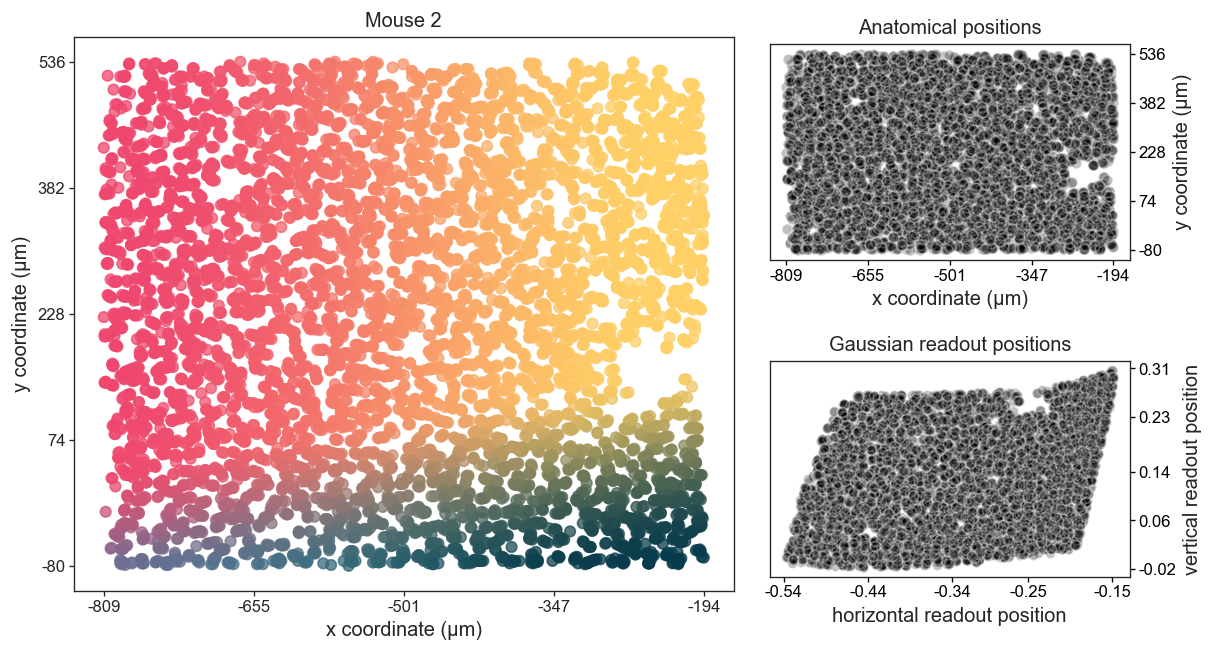

In [141]:
plot_readout_coordinate_map(
    mouse_id=MOUSE_ID,
    coordinates=neuron_coordinates,
    positions=readout_positions,
    filename=os.path.join(f"plots/mouse{MOUSE_ID}_readout_coordinate_maps.svg"),
)